In [1]:
# load model

import cobra
import numpy as np
import matplotlib.pyplot as plt

# model originally from:
# Caspeta L, Shoaie S, Agren R, et al (2012) Genome-scale metabolic reconstructions of Pichia stipitis and Pichia pastoris and in silico evaluation of their potentials. BMC Syst Biol 6:24. doi: 10.1186/1752-0509-6-24.

# model with heterologous protein production was used as starting point for our simulation:
# Irani ZA, Kerkhoven EJ, Shojaosadati SA, Nielsen J (2016) Genome-scale metabolic model of Pichia pastoris with native and humanized glycosylation of recombinant proteins. Biotechnol Bioeng 113:961–969. doi: 10.1002/bit.25863.

# it is common for these models to give some warnings when uploaded for the first time, so in order to avoid them, it is just required to rewrite the model as follows

#pheast = cobra.io.read_sbml_model("./data/iLC915.xml")
#cobra.io.write_sbml_model(pheast,"./data/iLC915_rewritten.xml")

pheast = cobra.io.read_sbml_model("./data/iLC915_rewritten.xml")

In [2]:
# first remove the heterologous protein production reactions from the paper

pheast.remove_reactions([pheast.reactions.r1337,
                        pheast.reactions.r1338,
                        pheast.reactions.r1100,
                        pheast.reactions.r1101,
                        pheast.reactions.r1102,
                        pheast.reactions.r1103,
                        pheast.reactions.EX_m1365])

pheast.remove_metabolites([pheast.metabolites.m1360,
                          pheast.metabolites.m1361,
                          pheast.metabolites.m1362,
                          pheast.metabolites.m1363,
                          pheast.metabolites.m1364,
                          pheast.metabolites.m1365])

/home/schmackeroodle/.local/lib/python3.9/site-packages/cobra/core/group.py:107: UserWarning: need to pass in a list
  warn("need to pass in a list")


In [3]:
# run the model/optimizes for cell growth

pheast.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
m1293,EX_m1293,1,0,0.00%
m1298,EX_m1298,0.7968,0,0.00%
m1300,EX_m1300,0.4628,0,0.00%
m1301,EX_m1301,0.03308,0,0.00%
m1304,EX_m1304,0.00246,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
m1287,EX_m1287,-0.0803,0,0.00%
m1291,EX_m1291,-1.597,0,0.00%
m1349,EX_m1349,-3.432,0,0.00%


In [4]:
# find glucose reactions (it can be seen that it is the carbon source being taken up at 1 mmol gDW^-1 h^-1)

pheast.metabolites.m1293.reactions

frozenset({<Reaction EX_m1293 at 0x7fd1ec41dfa0>,
           <Reaction r1145 at 0x7fd1ec31f910>})

In [5]:
# exchange reaction in general

pheast.reactions.EX_m1293


Reaction identifier,EX_m1293
Name,EX_m1293
Memory address,0x07fd1ec41dfa0
Stoichiometry,m1293 <=> alpha-D-Glucose_C6H12O6 <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [110]:
# this reaction seems to be the uptake from medium (it is defined in this model as boundary metabolites -> extracellular --> cytosolic
# and we have to define the medium boudary at reaction from boundary to extracellular)

pheast.reactions.r1145


Reaction identifier,r1145
Name,Uptake of alpha-D-Glucose
Memory address,0x07fef90a7adc0
Stoichiometry,m1293 --> m2 alpha-D-Glucose_C6H12O6 --> alpha-D-Glucose_C6H12O6
GPR,
Lower bound,0.0
Upper bound,1.0


In [111]:
# look for methanol

pheast.reactions.query("methanol", "name")

[<Reaction r1158 at 0x7fef90a0e940>]

In [112]:
# this is methanol uptake

pheast.reactions.r1158

Reaction identifier,r1158
Name,uptake of methanol
Memory address,0x07fef90a0e940
Stoichiometry,m1297 --> m1219 Methanol_CH4O --> Methanol_CH4O
GPR,
Lower bound,0.0
Upper bound,0.0


In [58]:
pheast.reactions.r1145.bounds = 0, 0  # no glucose 
pheast.reactions.r1158.bounds = 0, 1  # methanol at 1 mmol gDW^-1 h^-1

In [114]:
# it grows on methanol
pheast.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
m1297,EX_m1297,1,0,0.00%
m1298,EX_m1298,1.258,0,0.00%
m1300,EX_m1300,0.06602,0,0.00%
m1301,EX_m1301,0.004719,0,0.00%
m1304,EX_m1304,0.0003508,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
m1287,EX_m1287,-0.01145,0,0.00%
m1291,EX_m1291,-0.372,0,0.00%
m1349,EX_m1349,-1.643,0,0.00%


In [115]:
# no methane yet

pheast.metabolites.query("methane", "name")

[]

In [59]:
# we add methane

b_methane = cobra.Metabolite(
    'b_methane',
    formula='CH4',
    name='boundary_methane',
    compartment='C_b')
e_methane = cobra.Metabolite(
    'e_methane',
    formula='CH4',
    name='extracellular_methane',
    compartment='C_e')

pheast.add_metabolites([b_methane,e_methane])

In [60]:
# make reactions

EX_methane = cobra.Reaction(
            'EX_methane',
            name = 'Exchange Reaction Methane',
            lower_bound = -1000,
            upper_bound = 1000,
        )

uptake_methane = cobra.Reaction(
            'uptake_methane',
            name = 'Methane Uptake from Environent',
            lower_bound = 0,
            upper_bound = 1.0 # for now we allow a max uptake of methane of 1 mmol gDW^-1 h^-1
        )

methane_oxidation = cobra.Reaction(
            'methane_oxidation',
            name = 'methane oxidation',
            lower_bound = 0.0,
            upper_bound = 1000.0
    )

# add involved metabolites and stoichiometry

EX_methane.add_metabolites(
    {
        pheast.metabolites.b_methane: -1.0,
    }
)

uptake_methane.add_metabolites(
    {
        pheast.metabolites.b_methane: -1.0,
        pheast.metabolites.e_methane: 1.0
    }
)

# pMMO reaction without redox coenzyme (in literature mostly ubiquinol is mentioned but neither is there
# cytosolic ubiqunol in this model (only in mitochondria), nor does the literature agree on what its role may be exactly )

methane_oxidation.add_metabolites(
    {
        pheast.metabolites.e_methane: -1.0,
        pheast.metabolites.m1232: -1.0,
        pheast.metabolites.m1215: 1.0,
        pheast.metabolites.m139: 1.0,
    }
)

# add gene dependency for pMMO

methane_oxidation.gene_reaction_rule = 'AOX_pMMO'

# add reactions to pheast

pheast.add_reactions([EX_methane,uptake_methane,methane_oxidation])

In [61]:
# set methanol uptake to 0 and try if it grows on methane

pheast.reactions.r1158.bounds = 0, 0

In [62]:
# it grows on methane

pheast.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
m1298,EX_m1298,1.815,0,0.00%
m1300,EX_m1300,0.03301,0,0.00%
m1301,EX_m1301,0.002359,0,0.00%
m1304,EX_m1304,0.0001754,0,0.00%
b_methane,EX_methane,1,1,100.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
m1287,EX_m1287,-0.005727,0,0.00%
m1291,EX_m1291,-0.686,0,0.00%
m1349,EX_m1349,-2.194,0,0.00%


In [120]:
# we will now introduce our heterologous protein: leghemoglobin
# we look at the detoxification pathway as there is a heme group in both catalase and hemoglobin which could
# influence our system in general and reaction we introduce for production of (leg)hemoglobin

pheast.metabolites.query("H2O2","name")

[<Metabolite m118 at 0x7fef92e62af0>,
 <Metabolite m139 at 0x7fef92e62ee0>,
 <Metabolite m140 at 0x7fef92e62f10>,
 <Metabolite m713 at 0x7fef9107ea60>,
 <Metabolite m1179 at 0x7fef911032e0>]

In [121]:
# this is the peroxisomal H2O2

pheast.metabolites.m713

Metabolite identifier,m713
Name,H2O2_H2O2
Memory address,0x07fef9107ea60
Formula,
Compartment,C_p
In 16 reaction(s),"r218, r134, r224, r215, r217, r225, r91, r226, r216, r1088, r219, r221, r223, r220, r222, r99"


In [122]:
# this is the catalase reaction, heme is not considered

pheast.reactions.r99

Reaction identifier,r99
Name,hydrogen-peroxide:hydrogen-peroxide oxidoreductase
Memory address,0x07fef90b65fd0
Stoichiometry,2.0 m713 --> 2.0 m65 2.0 H2O2_H2O2 --> 2.0 H2O_H2O
GPR,PAS_chr2-2_0131
Lower bound,0.0
Upper bound,1000.0


In [123]:
# we find there is a heme metabolite

pheast.metabolites.query("heme","name")

[<Metabolite m1053 at 0x7fef99406b20>]

In [124]:
# it is siroheme

pheast.metabolites.m1056

Metabolite identifier,m1056
Name,Coproporphyrinogen I_C36H44N4O8
Memory address,0x07fef99406bb0
Formula,
Compartment,C_c
In 1 reaction(s),r860


In [125]:
# only involved in this reaction; it is also specifically a species of heme different from the one in catalse
# and hemoglobin, so we should not take this one
pheast.reactions.r973

Reaction identifier,r973
Name,S-Adenosyl-L-methionine:uroporphyrin-III C-methyltransferase
Memory address,0x07fef90d42be0
Stoichiometry,m1052 + m564 --> m1053 + 2.0 m16 Sirohydrochlorin_C42H46N4O16 + Fe2+_Fe --> Siroheme_C42H44FeN4O16 + 2.0 H+_H
GPR,PAS_chr1-4_0222
Lower bound,0.0
Upper bound,1000.0


In [126]:
# there are also a bunch of porypherin metabolites which are similar to the hemoglobin

pheast.metabolites.query("porphyrin","name")

#    A. Díaz, P.C. Loewen, I. Fita, X. Carpena
#    Thirty years of heme catalases structural biology
#    Arch. Biochem. Biophys., 525 (2012), pp. 102-110

# According to the source above C34-heme b is the most abundant, so we could go for that (there are some C34
# poryphyrins) and introduce it in the catalase and later hemoglobin reaction but none are in the peroxisome

[<Metabolite m1045 at 0x7fef994069a0>,
 <Metabolite m1046 at 0x7fef994069d0>,
 <Metabolite m1047 at 0x7fef99406a00>,
 <Metabolite m1048 at 0x7fef99406a30>,
 <Metabolite m1049 at 0x7fef99406a60>,
 <Metabolite m1055 at 0x7fef99406b80>,
 <Metabolite m1056 at 0x7fef99406bb0>,
 <Metabolite m1185 at 0x7fef91103400>]

In [63]:
# now we will introduce the heterologous proteins, pMMO and leghemoglobin, with reactions for dna replication,
# transcription and translation
# as the sequences are long, we calculate the stoichiometry with a script which is on the github repo and imported here
# based on the logic behind introduction of heterologous protein production in the paper:
# Irani ZA, Kerkhoven EJ, Shojaosadati SA, Nielsen J (2016) Genome-scale metabolic model of Pichia pastoris with native and humanized glycosylation of recombinant proteins. Biotechnol Bioeng 113:961–969. doi: 10.1002/bit.25863.
# for that we define the following function

import stoichiometry_gsm

def add_protein_reaction(model, reaction, lb, ub, seq, seq_type, protein_name):
    
    stoichiometry = stoichiometry_gsm.get_stoichiometry(seq, seq_type, protein_name)
    
    reaction = cobra.Reaction(
                reaction,
                name = reaction,
                lower_bound = lb,
                upper_bound = ub
        )
    
    for molecule in stoichiometry:
        reaction.add_metabolites(
            {
                getattr(model.metabolites, molecule): stoichiometry[molecule] 
            }
        )
    
    model.add_reactions([reaction])

In [64]:
# and get the sequences for our two recombinant proteins, pMMO and leghemoglobin. defined before in another file
from sequences import *

In [65]:
# add the metabolites to be produced by these reactions

pMMO_DNA = cobra.Metabolite(
    'pMMO_DNA',
    name='pMMO_DNA',
    compartment='C_c')

pMMO_RNA = cobra.Metabolite(
    'pMMO_RNA',
    name='pMMO_RNA',
    compartment='C_c')

pMMO_AA = cobra.Metabolite(
    'pMMO_AA',
    name='pMMO_AA',
    compartment='C_c')

hemo_DNA = cobra.Metabolite(
    'hemo_DNA',
    name='Hemo_DNA',
    compartment='C_c')

hemo_RNA = cobra.Metabolite(
    'hemo_RNA',
    name='Hemo_RNA',
    compartment='C_c')

hemo_AA = cobra.Metabolite(
    'hemo_AA',
    name='Leghemoglobin',
    compartment='C_c')


pheast.add_metabolites([pMMO_DNA,
                       pMMO_RNA,
                       pMMO_AA,
                       hemo_DNA,
                       hemo_RNA,
                       hemo_AA])

In [66]:
# make new reactions
# !! make sure the protein name is the same as you defined the metabolites, otherwise it will fail
add_protein_reaction(pheast, 'pMMO_DNA_reaction', 0, 1000, pMMO_dna_seq, 'dna', 'pMMO')
add_protein_reaction(pheast, 'pMMO_RNA_reaction', 0, 1000, pMMO_rna_seq, 'rna', 'pMMO')
add_protein_reaction(pheast, 'pMMO_AA_reaction', 0, 1000, pMMO_aa_seq, 'aa', 'pMMO')
add_protein_reaction(pheast, 'hemo_DNA_reaction', 0, 1000, hemo_dna_seq, 'dna', 'hemo')
add_protein_reaction(pheast, 'hemo_RNA_reaction', 0, 1000, hemo_rna_seq, 'rna', 'hemo')
add_protein_reaction(pheast, 'hemo_AA_reaction', 0, 1000, hemo_aa_seq, 'aa', 'hemo')

In [67]:
# also add transport to extracellular and boundary proteins as well as "Biosynthesis" reactions and the exchange reaction
# this was all done in the paper

pMMO_c = cobra.Metabolite(
    'pMMO_c',
    formula='',
    name='pMMO_c',
    compartment='C_c')

pMMO_e = cobra.Metabolite(
    'pMMO_e',
    formula='',
    name='pMMO_e',
    compartment='C_e')

pMMO_b = cobra.Metabolite(
    'pMMO_b',
    formula='',
    name='pMMO_b',
    compartment='C_b')

hemo_c = cobra.Metabolite(
    'hemo_c',
    formula='',
    name='hemo_c',
    compartment='C_c')

hemo_e = cobra.Metabolite(
    'hemo_e',
    formula='',
    name='hemo_e',
    compartment='C_e')

hemo_b = cobra.Metabolite(
    'hemo_b',
    formula='',
    name='hemo_b',
    compartment='C_b')

pheast.add_metabolites([pMMO_c,pMMO_e,pMMO_b,
                      hemo_c,hemo_e,hemo_b])


pMMO_Biosynthesis = cobra.Reaction(
            'pMMO_Biosynthesis',
            name = 'pMMO Biosynthesis',
            lower_bound = 0.0,
            upper_bound = 1000.0
)

hemo_Biosynthesis = cobra.Reaction(
            'hemo_Biosynthesis',
            name = 'Leghemoglobin Biosynthesis',
            lower_bound = 0.0,
            upper_bound = 1000.0
)

extrac_pMMO = cobra.Reaction(
            'c_pMMO_e',
            name = 'extracellular transport pMMO',
            lower_bound = 0.0,
            upper_bound = 1000.0
)

extrac_Hemo = cobra.Reaction(
            'c_Hemo_e',
            name = 'extracellular transport Leghemoglobin',
            lower_bound = 0.0,
            upper_bound = 1000.0
)

Take_Out_Hemo = cobra.Reaction(
            'e_Hemo_b',
            name = 'Take_Out_Hemo',
            lower_bound = 0.0,
            upper_bound = 1000.0
)

Take_Out_pMMO = cobra.Reaction(
            'e_pMMO_b',
            name = 'Take_Out_pMMO',
            lower_bound = 0.0,
            upper_bound = 1000.0
)

EX_hemo = cobra.Reaction(
            'EX_hemo',
            name = 'Leghemoglobin exchange reaction',
            lower_bound = -1000.0,
            upper_bound = 1000.0
)

EX_pMMO = cobra.Reaction(
            'EX_pMMO',
            name = 'pMMO exchange reaction',
            lower_bound = -1000.0,
            upper_bound = 1000.0
)

hemo_Biosynthesis.add_metabolites(
    {
        pheast.metabolites.hemo_DNA: -2.8e-05,
        
        pheast.metabolites.hemo_RNA: -0.0029,
        
        pheast.metabolites.hemo_AA: -0.997,

        pheast.metabolites.hemo_c: 1.0,
    }
)

pMMO_Biosynthesis.add_metabolites(
    {       
        pheast.metabolites.pMMO_DNA: -2.8e-05,
        
        pheast.metabolites.pMMO_RNA: -0.0029,
        
        pheast.metabolites.pMMO_AA: -0.997,

        pheast.metabolites.pMMO_c: 1.0,
    }
)

extrac_pMMO.add_metabolites(
    {
        pheast.metabolites.pMMO_c: -1.0,   
        
        pheast.metabolites.pMMO_e: 1.0
    }
)

extrac_Hemo.add_metabolites(
    {
        pheast.metabolites.hemo_c: -1.0,   
        
        pheast.metabolites.hemo_e: 1.0
    }
)

Take_Out_pMMO.add_metabolites(
    {
        pheast.metabolites.pMMO_e: -1.0,   
        
        pheast.metabolites.pMMO_b: 1.0
        
    }
)

Take_Out_Hemo.add_metabolites(
    {
        pheast.metabolites.hemo_e: -1.0,   
        
        pheast.metabolites.hemo_b: 1.0
    }
)

EX_pMMO.add_metabolites(
    {
        pheast.metabolites.pMMO_b: -1.0
    }
)

EX_hemo.add_metabolites(
    {
        pheast.metabolites.hemo_b: -1.0
    }
)

pheast.add_reactions([Take_Out_Hemo,
                    Take_Out_pMMO,
                    extrac_pMMO,
                    extrac_Hemo,
                    pMMO_Biosynthesis,
                    hemo_Biosynthesis,
                    EX_hemo,
                    EX_pMMO])

In [68]:
# final biomass production of pheast

pheast.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
m1298,EX_m1298,1.815,0,0.00%
m1300,EX_m1300,0.03301,0,0.00%
m1301,EX_m1301,0.002359,0,0.00%
m1304,EX_m1304,0.0001754,0,0.00%
b_methane,EX_methane,1,1,100.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
m1287,EX_m1287,-0.005727,0,0.00%
m1291,EX_m1291,-0.686,0,0.00%
m1349,EX_m1349,-2.194,0,0.00%


In [130]:
# set Biomass reaction to the optimized value and optimize for protein production

# pheast.reactions.r1339.bounds = 0,0

In [69]:
pheast.objective = pheast.problem.Objective(pheast.reactions.hemo_Biosynthesis.flux_expression)
pheast_final = pheast.copy()
pheast.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
m1298,EX_m1298,1.742,0,0.00%
m1300,EX_m1300,0.08749,0,0.00%
m1301,EX_m1301,7.672E-05,0,0.00%
m1304,EX_m1304,0.0004926,0,0.00%
b_methane,EX_methane,1,1,100.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
hemo_b,EX_hemo,-0.008953,0,0.00%
m1291,EX_m1291,-0.651,0,0.00%
m1349,EX_m1349,-2.009,0,0.00%


In [132]:
cobra.summary.MetaboliteSummary(metabolite = pheast.metabolites.hemo_c, model = pheast)

Percent,Flux,Reaction,Definition
100.00%,0.007661,hemo_Biosynthesis,0.997 hemo_AA + 2.8e-05 hemo_DNA + 0.0029 hemo_RNA --> hemo_c
Percent,Flux,Reaction,Definition
100.00%,-0.007661,c_Hemo_e,hemo_c --> hemo_e


In [133]:
cobra.summary.reaction_summary.ReactionSummary(reaction = pheast.reactions.uptake_methane, model = pheast)

In [134]:
# we can try different scenarios of the methane oxidation reaction:

# amount of protein in yeast cell is about 50% of the gDW
# https://bionumbers.hms.harvard.edu/bionumber.aspx?&id=102328

# AOX expression accounts for 5-30% --> thus we take 3 scenarios in which pMMO makes up (1)5, (2)10 and (3)20% of
# total protein per gram DW
# Couderc, R., & Baratti, J. (1980). Oxidation of methanol by the yeast, Pichia pastoris. Purification and properties of the alcohol oxidase. Agricultural and biological chemistry, 44(10), 2279-2289.
# Vogl, T., & Glieder, A. (2013). Regulation of Pichia pastoris promoters and its consequences for protein production. New biotechnology, 30(4), 385-404.
# expression under GAP in glucose medium can reach even higher ones compared to AOX in methanol :
# Karaoglan, M., Karaoglan, F. E., & Inan, M. (2016). Comparison of ADH3 promoter with commonly used promoters for recombinant protein production in Pichia pastoris. Protein expression and purification, 121, 112-117.
# Waterham, H. R., Digan, M. E., Koutz, P. J., Lair, S. V., & Cregg, J. M. (1997). Isolation of the Pichia pastoris glyceraldehyde-3-phosphate dehydrogenase gene and regulation and use of its promoter. Gene, 186(1), 37-44.
# We leave that question open as there are no good absolute numbers and we cannot simulate switching media which we will do in vitro/vivo.


# as the turnover rate for the pMMO is estimated/measured at about 0.5-2.5 s^-1, we choose 1 s^-1 as a conservative parameter
# for our pMMO (also corresponds to a conservative estimate from measured specific activities as can be compared below)
# Hakemian, A. S., & Rosenzweig, A. C. (2007). The biochemistry of methane oxidation. Annu. Rev. Biochem., 76, 223-241. : spec. activ. 10-200 nmol/min/mg-total-prot === 0.3-6 mmol/h/gDW
# Sirajuddin, S., & Rosenzweig, A. C. (2015). Enzymatic oxidation of methane. Biochemistry, 54(14), 2283-2294. : specific activities of 17-160 === 0.51-4.8 mmol/h/gDW
# Nguyen, H. H., Shiemke, A. K., Jacobs, S. J., Hales, B. J., Lidstrom, M. E., & Chan, S. I. (1994). The nature of the copper ions in the membranes containing the particulate methane monooxygenase from Methylococcus capsulatus (Bath). Journal of Biological Chemistry, 269(21), 14995-15005. : specific activities dependent on copper but in range 10-50 ==== 0.3-1.5


# mass of pMMO is about 300 kDA
# Ross, M. O., & Rosenzweig, A. C. (2017). A tale of two methane monooxygenases. JBIC Journal of Biological Inorganic Chemistry, 22(2-3), 307-319.
# one pMMO has a weight of about 4.981620599999999e-19 g

# --> in one gDW there will be (calculations showed below)
# (1) 0.025g/gDW pMMO --> 5.0184472e+16 molecules of pMMO/gDW --> 0.29999978778 mmol of CH4/gDW -> CH3OH mmol/gDW h
# (2) 0.05g/gDW pMMO --> 1.0036894e+17 molecules of pMMO/gDW --> 0.59999955165 mmol of CH4/gDW -> CH3OH mmol/gDW h
# (3) 0.1g/gDW pMMO --> 2.0073789e+17 molecules of pMMO/gDw --> 1.19999916309 mmol of CH4/gDW -> CH3OH mmol/gDW h

# e.g. pheast.reactions.methane_oxidation.bounds = -1000,0.59999955165
# or at the uptake level: pheast.reactions.uptake_methane = 0,1.19999916309

# --> pheast will metabolize as much methane as possible due to constraints of pMMO and methane availability
# --> In a good scenario in which 20% of the total cell protein is pMMO, about 1.2 mmol/gDW/h corresponding to
# about 0.02 g / 0.03 ml of methane per gDW/h (at a temperature of 37 degrees C with a CH4 density of 0.623 kg/m3) 
# (https://www.engineeringtoolbox.com/methane-density-specific-weight-temperature-pressure-d_2020.html)
# are needed to reach maximal efficiency (limited by pMMO activity)
# thus the process will have a bottleneck at the fermentation technology level

# --> on the other hand if we expect to have at least 5% of the total cell protein to be functional pMMO with the
# given turnover rate as 1, per gDW/h the culture would need 0.00772391 ml of methane to use it optimally

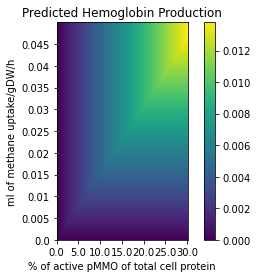

In [179]:
def methane_ml_to_mmol_at_37(ml):
    molar_mass_methane = 0.01604 # g/mmol
    methane_density = 0.623 # g/ml
    return(ml*methane_density/molar_mass_methane)

def make_plot(model, precision, max_pMMO_percent):
    
    pMMO_weight = 4.981620599999999E-19 # g/molecule
    Avogadro = 6.0221409E+23 # molecules/mol
    turnover = 1 # 1/s

    # vector for pMMO percentage
    pMMO_percentages = list(np.arange(0,max_pMMO_percent+precision,precision))

    # from best case scenario we can say that 0.03ml is max methane uptake /gDW/h; we set it to 0.05 as we also
    # simulate 30% protein here and it is good to have some margin in any case
    
    
    methane_concentrations = list(np.arange(0,0.05,0.0001))

    # results matrix
    plot = np.zeros([len(methane_concentrations),len(pMMO_percentages)])
    
    xticks = []
    yticks = set()
    
    for index1,pMMO in enumerate(pMMO_percentages):
        xticks.append(index1)
        for index2,methane in enumerate(methane_concentrations):
            yticks.add(index2)
            # calculate potential methane consumption
            # 1. convert g/gDW of pMMO to molecules to mmol/gDW h
            # weight of pMMO = 4.981620599999999e-19 g, 0.5 as 50% protein in cell, 6E+23 avogadro's number,
            # 1000 because of mmol <-> mol, turonver to get mmol/ gDW s, 3600 s <-> h
            mmol = ((pMMO/100)*0.5) / pMMO_weight / Avogadro * 1000 * turnover * 3600
        
            # set uptake and optimise
            pheast.reactions.uptake_methane.bounds = 0,methane_ml_to_mmol_at_37(methane)
            pheast.reactions.methane_oxidation.bounds = 0,mmol
            plot[index2,index1] = pheast.optimize().objective_value            
    
    yticks = list(yticks)
    imgplot = plt.imshow(plot,extent=[0,len(pMMO_percentages),len(methane_concentrations),0])
    plt.colorbar()
    plt.title("Predicted Hemoglobin Production")
    plt.xlabel("% of active pMMO of total cell protein")
    plt.ylabel("ml of methane uptake/gDW/h")
    plt.gca().invert_yaxis()
    label_meth = methane_concentrations
    label_pMMO = pMMO_percentages
    plt.xticks([round(xticks[i],3) for i in range(0,len(xticks),50)], [round(label_pMMO[i],3) for i in range(0,len(label_pMMO),50)])
    plt.yticks([round(yticks[i],3) for i in range(0,len(yticks),50)], [round(label_meth[i],3) for i in range(0,len(label_meth),50)])


make_plot(pheast,0.1,30)

In [178]:
# thus the max yield of hemoglobin at a methane uptake at about 1.8 mmol/gDW/h wit 30% of total cellular
# protein being functional pMMO would be (in a scenario knocking out the AOX)

pheast.reactions.uptake_methane.bounds = 0,1.8
pheast.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
m1298,EX_m1298,3.166,0,0.00%
m1300,EX_m1300,0.1575,0,0.00%
m1301,EX_m1301,0.000126,0,0.00%
m1304,EX_m1304,0.0008869,0,0.00%
b_methane,EX_methane,1.8,1,100.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
hemo_b,EX_hemo,-0.01379,0,0.00%
m1291,EX_m1291,-1.172,0,0.00%
m1349,EX_m1349,-3.676,0,0.00%


## Plotting image plots

Now, we want to use our new model that simulates our K. phaffii status to analyze the optimal environmental conditions for the maximal protein production. First of all, we will focus on oxygen and methane, as the unique carbon source considered.

In [138]:
# plotting of the potential protein production as a function of methane and oxygen uptake

# we create a function to see how our protein production is optimize on different environments
def image_plot(model, precision, max_met, max_ox):
    plot = np.zeros([precision, precision])
    methane_vec = np.linspace(0,max_met,precision); oxygen_vec = np.linspace(0,max_ox,precision)
    for count_ox, oxygen in enumerate(oxygen_vec):
        for count_met, met in enumerate(methane_vec):
            #print(met, oxygen)
            model.reactions.r1160.bounds = oxygen, oxygen
            model.reactions.uptake_methane.bounds = met, met 
            result = model.optimize().objective_value
            if result < 0: 
                result = 0
            plot[(precision-1 - count_ox), count_met] = result
    label_met = np.round(np.linspace(0, max_met, 6),1)
    label_ox = np.round(np.linspace(max_ox, 0,6),1)
    ticks = np.linspace(0, precision - 1,6)
    imgplot = plt.imshow(plot)
    plt.colorbar()
    #plt.gca().invert_yaxis()
    plt.title("Optimization of protein production on different environment uptake")
    plt.xlabel("Methane uptake")
    plt.ylabel("Oxygen uptake")
    plt.xticks(ticks, label_met)
    plt.yticks(ticks, label_ox)
    plt.grid()
    return plot

max_met = 5; max_ox = 20; precision = 100
plot = image_plot(pheast_final, precision, max_met, max_ox)

NameError: name 'pheast_final' is not defined